In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn

In [15]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )
    
    def forward(self,x):
        return self.net(x)

In [16]:
class Problem_Definition:
    def __init__(self):
        
        self.model = PINN()
        
        self.h = 0.1 
        self.k = 0.1
        
        x = torch.arange(-1,1+self.h,self.h)
        t = torch.arange(0,1+self.k,self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T 
        
        # Boundary conditions
        
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        
        
        # Initial condition
    
        ic = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1,bc2,ic])
        
        # Initializing Targets
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:,0])
        
        self.Y1_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.Y_train = self.Y1_train.unsqueeze(1)
        
    
        self.X.requires_grad = True
       
     # Test 
        """
        print(self.X.shape)
        print(ic.shape)
        print(bc1.shape)
        print(bc2.shape)
        print(self.X_train.shape)
        print('-'*100)
        print(y_ic.shape)
        print(y_bc1.shape)
        print(y_bc2.shape)
        print(self.Y1_train.shape)
        print(self.Y_train.shape) """
        
    
      # Optimizer
        
        self.adam = torch.optim.Adam(self.model.parameters(),1e-3)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        Y_pred = self.model(self.X_train)
        loss_data = self.criterion(Y_pred,self.Y_train)
        
        u = self.model(self.X)
        
        dU_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0] # To get out of the tuple
        
        du_dx = dU_dX[:,0]
        du_dt = dU_dX[:,1]
        
        dU_dXX = torch.autograd.grad(
            dU_dX,
            self.X,
            grad_outputs = torch.ones_like(dU_dX),
            create_graph = True,
            retain_graph = True
        )[0] # To get out of the tuple
        
        du_dxx = dU_dXX[:,0]
        
        eqn = du_dt + u.squeeze()*du_dx - (0.01/math.pi)*du_dxx - torch.sin(self.X[:,0])* torch.cos(self.X[:,1])
        eqn_lhs = du_dt + u.squeeze()*du_dx 
        eqn_rhs = (0.01/math.pi)*du_dxx + torch.sin(self.X[:,0])* torch.cos(self.X[:,1])
        loss_pde = self.criterion(eqn,torch.zeros_like(eqn))
        


        loss = loss_data + loss_pde
        loss.backward()
        
        
        if self.iter% 100 == 0:
            print(f"Iteration : {self.iter}, Loss : {loss.item()}")
        self.iter = self.iter + 1
        
        return loss
        
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
   
    def eval_(self):
        self.model.eval()

In [17]:
# Execution
run = Problem_Definition()
run.train()

Iteration : 100, Loss : 0.15373893082141876
Iteration : 200, Loss : 0.09876307845115662
Iteration : 300, Loss : 0.0901913195848465
Iteration : 400, Loss : 0.08043285459280014
Iteration : 500, Loss : 0.0672798752784729
Iteration : 600, Loss : 0.06087706983089447
Iteration : 700, Loss : 0.05777246505022049
Iteration : 800, Loss : 0.054647695273160934
Iteration : 900, Loss : 0.04696403816342354
Iteration : 1000, Loss : 0.03886062279343605
Iteration : 1100, Loss : 0.025577357038855553
Iteration : 1200, Loss : 0.023755742236971855
Iteration : 1300, Loss : 0.022865716367959976
Iteration : 1400, Loss : 0.02242678962647915
Iteration : 1500, Loss : 0.022128403186798096
Iteration : 1600, Loss : 0.022008631378412247
Iteration : 1700, Loss : 0.021933365613222122
Iteration : 1800, Loss : 0.02183469757437706
Iteration : 1900, Loss : 0.021757572889328003
Iteration : 2000, Loss : 0.02170160412788391
Iteration : 2100, Loss : 0.02165677212178707
Iteration : 2200, Loss : 0.02162656933069229
Iteration : 2

In [18]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X

In [19]:
model = run.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).numpy()

In [20]:
y_pred

array([[ 1.0817349e-03, -6.4939260e-05, -9.5716119e-04, ...,
        -3.2539070e-03, -3.4250021e-03, -3.5901666e-03],
       [ 9.7259581e-03,  5.0336123e-03,  7.3796511e-04, ...,
        -9.0422183e-02, -9.0598077e-02, -9.0763599e-02],
       [ 3.4715682e-02,  2.7158648e-02,  2.0094424e-02, ...,
        -1.6084594e-01, -1.6113651e-01, -1.6141209e-01],
       ...,
       [-6.7105114e-02, -5.8727771e-02, -5.0795078e-02, ...,
         2.1114871e-01,  2.1168986e-01,  2.1217504e-01],
       [-3.7671953e-02, -3.1302810e-02, -2.5300890e-02, ...,
         1.5706959e-01,  1.5727600e-01,  1.5743282e-01],
       [-1.4560223e-02, -1.0537893e-02, -6.7986548e-03, ...,
         8.6543590e-02,  8.6446613e-02,  8.6310178e-02]], dtype=float32)

In [21]:
sns.set_style('white')
plt.figure(figsize=(5,3), dpi = 5000)
sns.heatmap(y_pred, cmap = 'jet')

<Axes: >

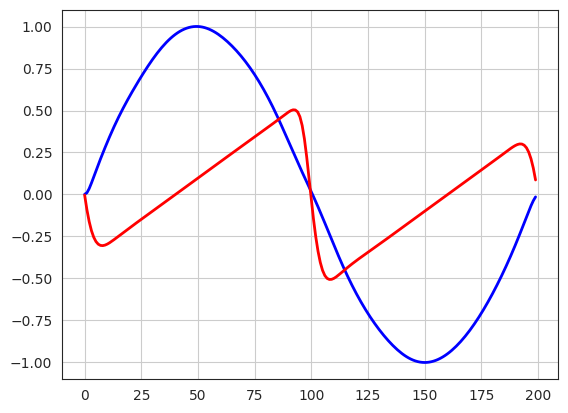

In [22]:
plt.figure(1)
plt.plot(y_pred[:,0], 'b', linewidth = 2)
plt.plot(y_pred[:,-1],'r', linewidth = 2)
plt.grid('True')
